В этом ноутбуке производится симуляция распространения инфекции по аэропортам, на основе датасета авиаперелетов в США (его части) с использованием библиоткеки networkx.

In [1]:
from collections import Counter
from datetime import datetime
from random import randint
from scipy.stats import spearmanr

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import seaborn as sns
import time
import warnings

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 12]
warnings.filterwarnings("ignore")

### Загрузка данных аэропортов

In [2]:
airport_data = pd.read_csv('airports.csv')

In [3]:
airport_data

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325
...,...,...,...,...,...,...,...,...
274,274,RDD,Redding Muni,Redding,40.509000,-122.293389,-1.976890e+06,334403.078441
275,275,SUN,Friedman Mem,Hailey,43.504444,-114.296194,-1.261565e+06,515731.793677
276,276,TWF,Magic Valley Regional Airport,Twin Falls,42.481803,-114.487733,-1.296508e+06,406881.420680
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander,45.631200,-89.467500,7.102613e+05,678171.825235


### Сортировка перелетов по времени вылета

In [4]:
flight_data = pd.read_csv('flights.csv', sep=' ')
flight_data = flight_data.sort_index().sort_values('StartTime', kind='mergesort')
flight_data

,Source,Destination,StartTime,EndTime,Duration
16150,27,49,1229231100,1229246760,15660
16997,30,2,1229233200,1229245980,12780
14055,251,20,1229235000,1229246340,11340
2160,180,20,1229235300,1229245500,10200
4463,12,4,1229235300,1229244960,9660
...,...,...,...,...,...
170670,246,24,1230104700,1230125640,20940
168992,55,23,1230105000,1230124740,19740
168893,55,24,1230105300,1230127200,21900
174360,56,32,1230105420,1230123060,17640


In [5]:
flight_data['StartTime'].unique().size

11299

### Часть 1. Пишем симуляцию.

In [6]:
def airport_contamination(df, airport_data, node_start=0, coef=0.01):
    infected = [node_start]
    airport_infected = [[df[df['Source'] == node_start]['StartTime'].min(),
                         airport_data[airport_data['id'] == node_start]['airport name'].values[0]]]
    for index, row in df.iterrows():
        if ((row['Source'] in infected) and (row['Destination'] not in infected)):
            if (randint(1, 100) <= (coef * 100)):
                infected.append(row['Destination'])
                airport_infected.append(
                    [row['EndTime'], airport_data[airport_data['id'] == row['Destination']]['airport name'].values[0]])
    return (airport_infected)


In [7]:
list = airport_contamination(flight_data, airport_data, node_start=0, coef=0.1)

In [8]:
list

[[1229245200, 'Lehigh Valley Intl'],
 [1229277300, 'Cleveland Hopkins Intl'],
 [1229283300, 'Orlando Intl'],
 [1229281800, 'Chicago Ohare Intl'],
 [1229280000, 'Gerald R Ford Intl'],
 [1229280000, 'Indianapolis Intl'],
 [1229287140, 'Newark Liberty Intl'],
 [1229284800, 'General Edward Lawrence Logan Intl'],
 [1229286300, 'George Bush Intcntl Houston'],
 [1229282040, 'Detroit Metro Wayne Co'],
 [1229288100, 'Miami Intl'],
 [1229282940, 'La Guardia'],
 [1229288400, 'Austin Bergstrom Intl'],
 [1229290620, 'Palm Beach Intl'],
 [1229281920, 'South Bend Rgnl'],
 [1229285520, 'Charlotte Douglas Intl'],
 [1229286780, 'Lincoln'],
 [1229283300, 'Dallas Fort Worth Intl'],
 [1229284140, 'Ronald Reagan Washington Natl'],
 [1229285520, 'Bradley Intl'],
 [1229295420, 'Phoenix Sky Harbor Intl'],
 [1229283300, 'Will Rogers World'],
 [1229290800, 'Jacksonville Intl'],
 [1229285100, 'Corpus Christi Intl'],
 [1229288820, 'Blue Grass'],
 [1229284440, 'Central Wisconsin'],
 [1229283840, 'Quad City Intl'],


### Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

In [9]:
coef_list = [0.01, 0.05, 0.1, 0.5, 1.]
iteration = 1
result = []
for coef in coef_list:
    list = []
    for i in range(iteration):
        list.append(airport_contamination(flight_data, airport_data, node_start=0, coef=coef))
    result.append({'coef': coef, 'list': list})


In [10]:
def airport_contamination_state(list, timemstart, timeend, airport_data):
    dt_object1 = datetime.fromtimestamp(timemstart)
    dt_object2 = datetime.fromtimestamp(timeend)
    rng = pd.date_range(start=dt_object1, end=dt_object2, freq='12H')
    outcome = []
    for result in list:
        l = [0] * rng.size
        for data in result['list']:
            #             dt=pd.DataFrame.from_dict(data, orient='index',columns=['name'])
            df = pd.DataFrame(data, columns=['time', 'name'])
            df = df.set_index('time')
            arr = []
            for date in rng:
                timestamp = time.mktime(datetime.strptime("{}".format(date), "%Y-%m-%d %H:%M:%S").timetuple())
                cnt = df[df.index <= timestamp].size
                arr.append(cnt)
            l = [x + y for x, y in zip(l, arr)]
        l = [x / len(result['list']) / airport_data.shape[0] * 100 for x in l]
        outcome.append({'coef': result['coef'], 'list': l})
    return (outcome)

In [11]:
data = airport_contamination_state(result, flight_data['StartTime'].min(), flight_data['EndTime'].max(), airport_data)

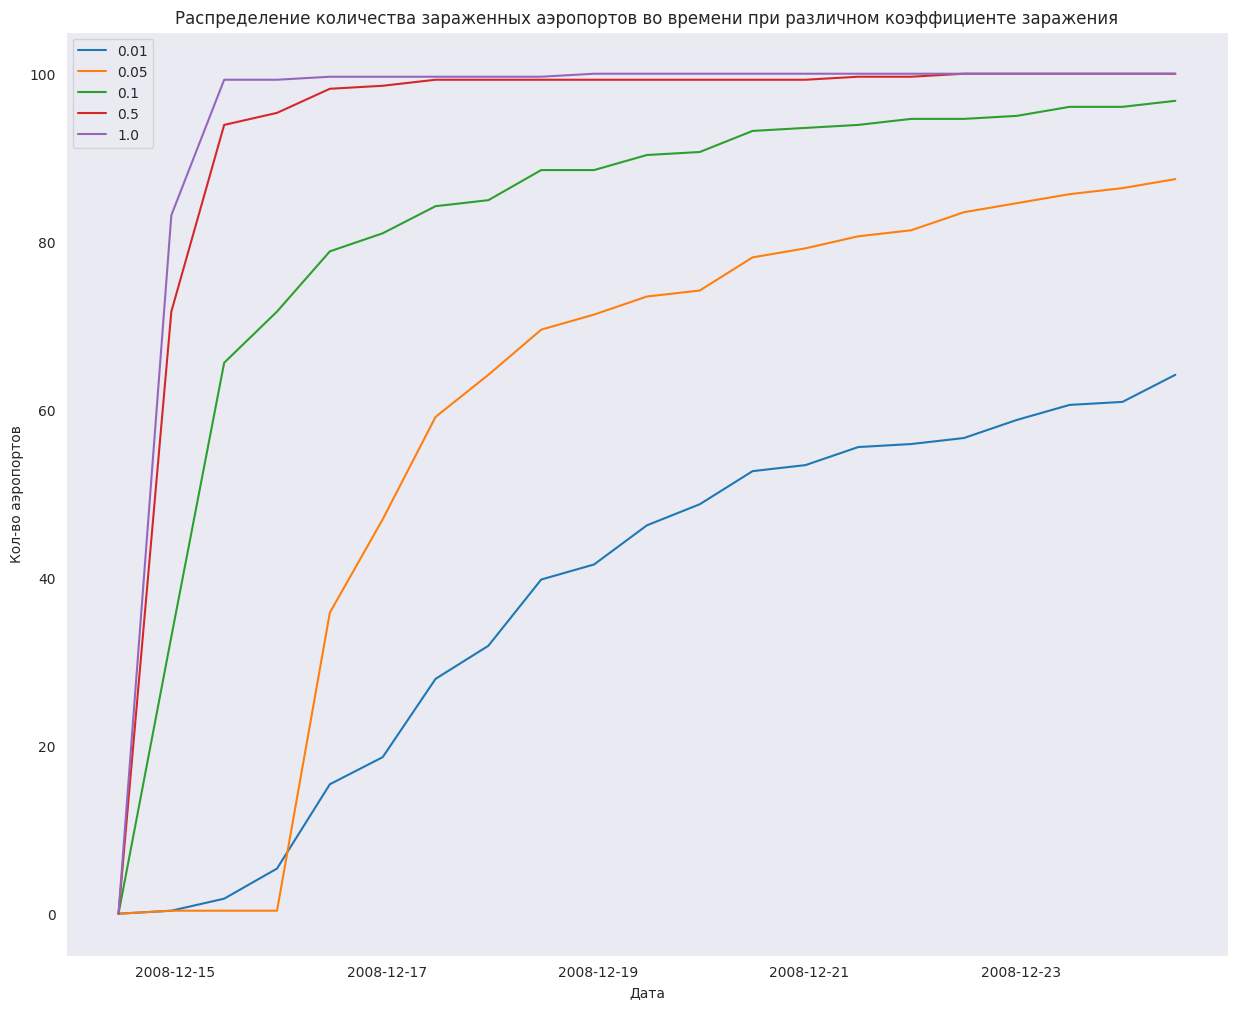

In [12]:
x = pd.date_range(start=datetime.fromtimestamp(flight_data['StartTime'].min()),
                  end=datetime.fromtimestamp(flight_data['EndTime'].max()), freq='12H')

plt.title("Распределение количества зараженных аэропортов во времени при различном коэффициенте заражения")
plt.xlabel("Дата")
plt.ylabel("Кол-во аэропортов")

plt.grid()

for dt in data:
    y = dt['list']
    label = dt['coef']
    plt.plot(x, y, label=label)
plt.legend()


### Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

In [13]:
flight_data

,Source,Destination,StartTime,EndTime,Duration
16150,27,49,1229231100,1229246760,15660
16997,30,2,1229233200,1229245980,12780
14055,251,20,1229235000,1229246340,11340
2160,180,20,1229235300,1229245500,10200
4463,12,4,1229235300,1229244960,9660
...,...,...,...,...,...
170670,246,24,1230104700,1230125640,20940
168992,55,23,1230105000,1230124740,19740
168893,55,24,1230105300,1230127200,21900
174360,56,32,1230105420,1230123060,17640


In [14]:
tmp = flight_data.copy()

In [15]:
df = pd.DataFrame([], columns=['Source', 'Destination', 'Count'])
df[(df['Source'] == 1) & df['Destination'] == 1].shape[0]

0

In [16]:
nodes = []
for index, row in airport_data.iterrows():
    nodes.append((row['id'], {'name': "{}:{}".format(row['city'], row['airport name'])}))
nodes

[(0, {'name': 'Allentown:Lehigh Valley Intl'}),
 (1, {'name': 'Cleveland:Cleveland Hopkins Intl'}),
 (2, {'name': 'Charlotte:Charlotte Douglas Intl'}),
 (3, {'name': 'Chicago:Chicago Ohare Intl'}),
 (4, {'name': 'Atlanta:Hartsfield Jackson Atlanta Intl'}),
 (5, {'name': 'Detroit:Detroit Metro Wayne Co'}),
 (6, {'name': 'Abilene:Abilene Rgnl'}),
 (7, {'name': 'Dallas-fort Worth:Dallas Fort Worth Intl'}),
 (8, {'name': 'Albuquerque:Albuquerque International Sunport'}),
 (9, {'name': 'Amarillo:Rick Husband Amarillo Intl'}),
 (10, {'name': 'Baltimore:Baltimore Washington Intl'}),
 (11, {'name': 'Dallas:Dallas Love Fld'}),
 (12, {'name': 'Denver:Denver Intl'}),
 (13, {'name': 'El Paso:El Paso Intl'}),
 (14, {'name': 'Houston:William P Hobby'}),
 (15, {'name': 'Las Vegas:Mc Carran Intl'}),
 (16, {'name': 'Los Angeles:Los Angeles Intl'}),
 (17, {'name': 'Lubbock:Lubbock Preston Smith Intl'}),
 (18, {'name': 'Midland:Midland Intl'}),
 (19, {'name': 'Kansas City:Kansas City Intl'}),
 (20, {'nam

In [17]:
df = pd.DataFrame([], columns=['Source', 'Destination', 'Count', 'Coef'])
flight_data_count = flight_data.shape[0]
elist = []
for index, row in tmp.iterrows():
    min_key = min(row['Source'], row['Destination'])
    max_key = max(row['Source'], row['Destination'])
    if (df[(df['Source'] == min_key) & (df['Destination'] == max_key)].shape[0] == 0):
        count_min = tmp[(tmp['Source'] == min_key) & (tmp['Destination'] == max_key)].shape[0]
        count_max = tmp[(tmp['Source'] == max_key) & (tmp['Destination'] == min_key)].shape[0]
        coef = (count_min + count_max) / flight_data_count
        df2 = pd.DataFrame([[min_key,
                             max_key,
                             count_min + count_max,
                             coef]],
                           columns=['Source', 'Destination', 'Count', 'Coef'])

        df = pd.concat([df, df2], ignore_index=True)
        elist.append((min_key, max_key, coef))

In [18]:
elist

[(27, 49, 0.0005549635943882081),
 (2, 30, 0.00011099271887764163),
 (20, 251, 0.00011099271887764163),
 (20, 180, 0.00011099271887764163),
 (4, 12, 0.0016704404191085064),
 (4, 16, 0.0014151571656899307),
 (7, 16, 0.0018702273130882614),
 (16, 34, 0.0007658497602557273),
 (32, 34, 0.000543864322500444),
 (31, 38, 0.0003329781566329249),
 (31, 32, 0.0008102468478067839),
 (26, 34, 0.0010599804652814775),
 (16, 31, 0.0011876220919907654),
 (7, 32, 0.0009878351980110104),
 (31, 106, 0.0003329781566329249),
 (15, 31, 0.0007658497602557273),
 (26, 41, 0.0016260433315574499),
 (23, 41, 0.00011099271887764163),
 (2, 47, 0.0018813265849760255),
 (49, 251, 9.989344698987746e-05),
 (27, 41, 0.00011099271887764163),
 (2, 20, 0.0009989344698987746),
 (31, 47, 0.0012431184514295863),
 (26, 51, 0.00022198543775528326),
 (15, 55, 0.00022198543775528326),
 (4, 96, 0.00022198543775528326),
 (48, 109, 0.0005993606819392648),
 (80, 109, 0.0006659563132658498),
 (10, 31, 0.000543864322500444),
 (31, 146,

In [19]:
G = nx.Graph()

In [20]:
G.add_nodes_from(nodes)

G.add_weighted_edges_from(elist)

In [21]:
G

In [22]:
G.number_of_nodes()

279

In [23]:
G.number_of_edges()

2088

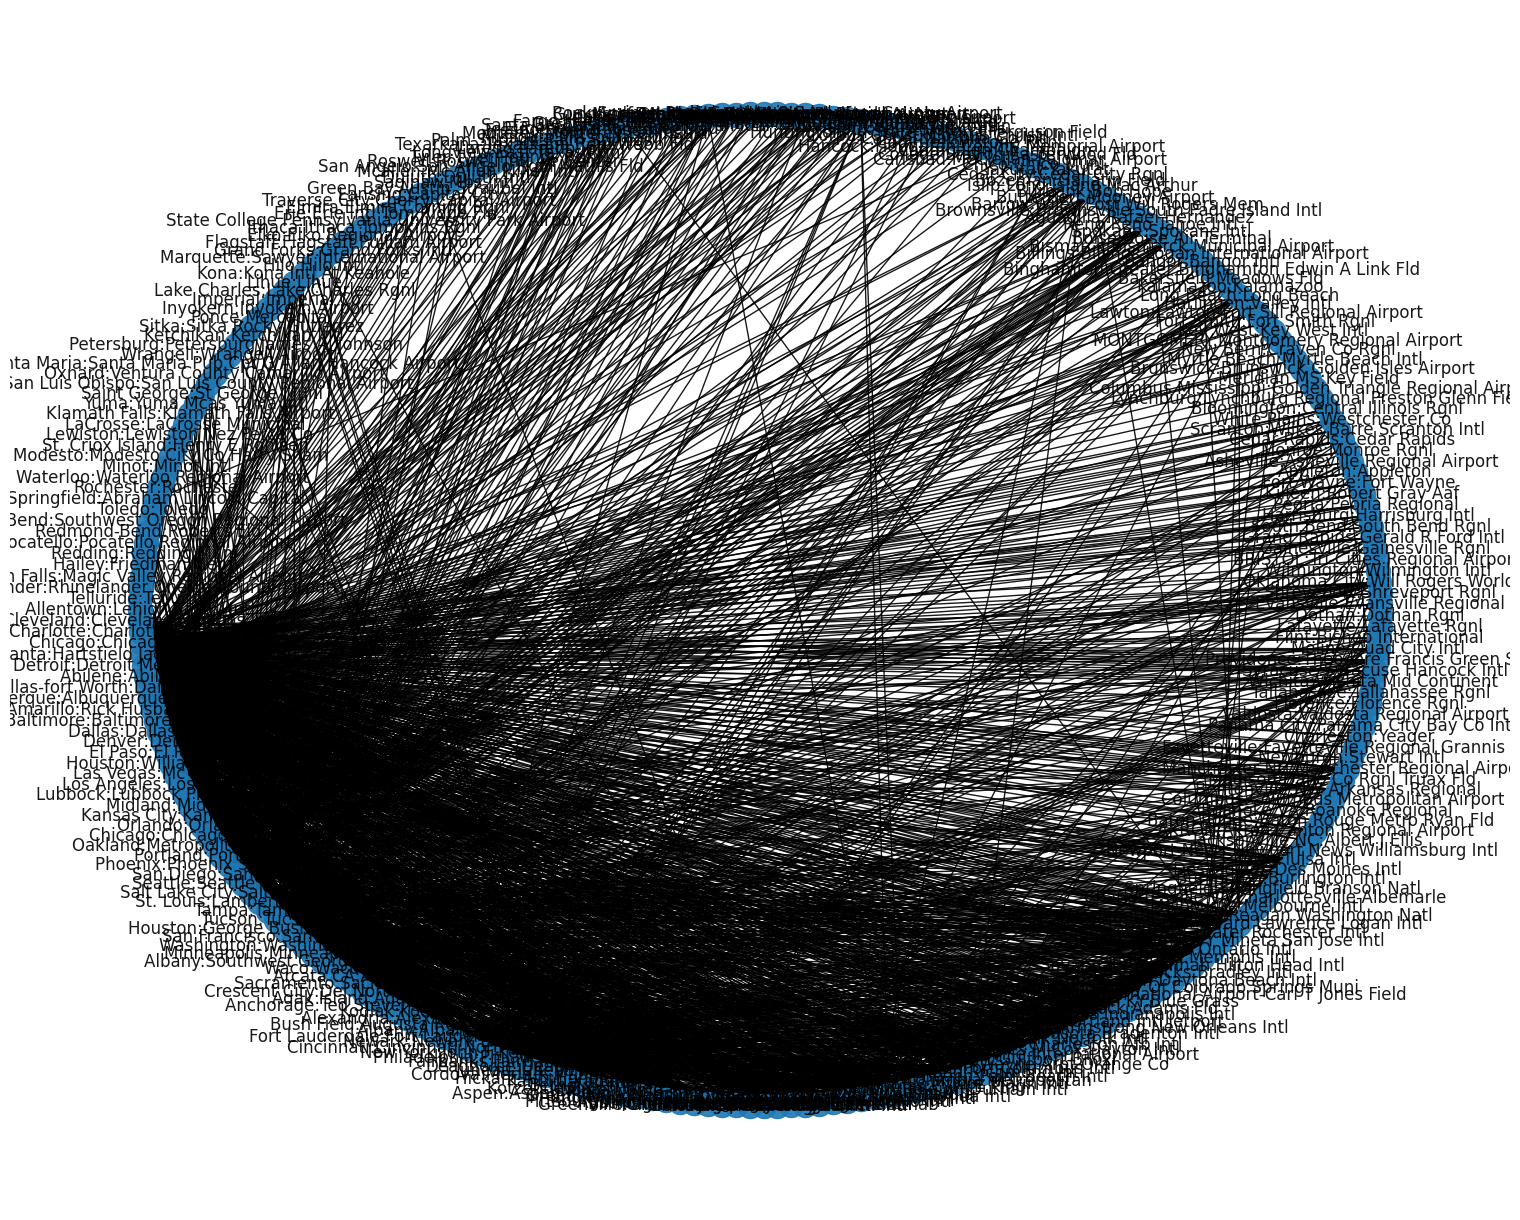

In [24]:
nx.draw_shell(G, alpha=0.9, labels={n[0]: n[1]['name'] for n in G.nodes.data()})

In [25]:
degree_centrality = nx.degree_centrality(G)
degree_centrality_counts = Counter(degree_centrality)
for k, v in degree_centrality_counts.most_common(10):
    print(G.nodes[k]['name'], v)

Atlanta:Hartsfield Jackson Atlanta Intl 0.5611510791366907
Chicago:Chicago Ohare Intl 0.4784172661870504
Dallas-fort Worth:Dallas Fort Worth Intl 0.45323741007194246
Detroit:Detroit Metro Wayne Co 0.3956834532374101
Denver:Denver Intl 0.3920863309352518
Houston:George Bush Intcntl Houston 0.3597122302158274
Minneapolis:Minneapolis St Paul Intl 0.3381294964028777
Salt Lake City:Salt Lake City Intl 0.3129496402877698
Cincinnati:Cincinnati Northern Kentucky Intl 0.302158273381295
Phoenix:Phoenix Sky Harbor Intl 0.2949640287769784


In [26]:
betweenness_centrality = nx.degree_centrality(G)

In [27]:
betweenness_centrality

{0: 0.017985611510791366,
 1: 0.20863309352517986,
 2: 0.23741007194244607,
 3: 0.4784172661870504,
 4: 0.5611510791366907,
 5: 0.3956834532374101,
 6: 0.0035971223021582736,
 7: 0.45323741007194246,
 8: 0.10431654676258993,
 9: 0.02158273381294964,
 10: 0.21582733812949642,
 11: 0.06474820143884892,
 12: 0.3920863309352518,
 13: 0.053956834532374105,
 14: 0.11510791366906475,
 15: 0.27697841726618705,
 16: 0.26618705035971224,
 17: 0.025179856115107917,
 18: 0.025179856115107917,
 19: 0.11870503597122303,
 20: 0.24820143884892087,
 21: 0.1798561151079137,
 22: 0.08992805755395684,
 23: 0.14028776978417268,
 24: 0.2949640287769784,
 25: 0.13309352517985612,
 26: 0.18345323741007194,
 27: 0.3129496402877698,
 28: 0.15827338129496404,
 29: 0.20503597122302158,
 30: 0.05755395683453238,
 31: 0.3597122302158274,
 32: 0.22302158273381295,
 33: 0.2302158273381295,
 34: 0.3381294964028777,
 35: 0.0035971223021582736,
 36: 0.0035971223021582736,
 37: 0.014388489208633094,
 38: 0.08633093525179

### Степень близости

In [28]:
closeness_centrality = nx.closeness_centrality(G)

In [29]:
closeness_centrality

{0: 0.42967542503863987,
 1: 0.5440313111545988,
 2: 0.5450980392156862,
 3: 0.6510538641686182,
 4: 0.6747572815533981,
 5: 0.6056644880174292,
 6: 0.3866481223922114,
 7: 0.6289592760180995,
 8: 0.5082266910420475,
 9: 0.4193061840120664,
 10: 0.5387596899224806,
 11: 0.4199395770392749,
 12: 0.6056644880174292,
 13: 0.4703891708967851,
 14: 0.4752136752136752,
 15: 0.5755693581780539,
 16: 0.562753036437247,
 17: 0.40406976744186046,
 18: 0.40406976744186046,
 19: 0.5148148148148148,
 20: 0.556,
 21: 0.5176908752327747,
 22: 0.4371069182389937,
 23: 0.5325670498084292,
 24: 0.5815899581589958,
 25: 0.5235404896421846,
 26: 0.5504950495049505,
 27: 0.587737843551797,
 28: 0.5295238095238095,
 29: 0.5295238095238095,
 30: 0.49466192170818507,
 31: 0.594017094017094,
 32: 0.549407114624506,
 33: 0.5504950495049505,
 34: 0.5965665236051502,
 35: 0.4034833091436865,
 36: 0.3866481223922114,
 37: 0.3792633015006821,
 38: 0.5054545454545455,
 39: 0.3554987212276215,
 40: 0.312710911136108,

In [30]:
airport_data['betweenness_centrality'] = pd.DataFrame.from_dict(betweenness_centrality, orient='index')
airport_data['degree_centrality'] = pd.DataFrame.from_dict(degree_centrality, orient='index')
airport_data['closeness_centrality'] = pd.DataFrame.from_dict(closeness_centrality, orient='index')
airport_data

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz,betweenness_centrality,degree_centrality,closeness_centrality
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978,0.017986,0.017986,0.429675
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074,0.208633,0.208633,0.544031
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565,0.237410,0.237410,0.545098
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396,0.478417,0.478417,0.651054
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325,0.561151,0.561151,0.674757
...,...,...,...,...,...,...,...,...,...,...,...
274,274,RDD,Redding Muni,Redding,40.509000,-122.293389,-1.976890e+06,334403.078441,0.003597,0.003597,0.355045
275,275,SUN,Friedman Mem,Hailey,43.504444,-114.296194,-1.261565e+06,515731.793677,0.003597,0.003597,0.370667
276,276,TWF,Magic Valley Regional Airport,Twin Falls,42.481803,-114.487733,-1.296508e+06,406881.420680,0.003597,0.003597,0.370667
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander,45.631200,-89.467500,7.102613e+05,678171.825235,0.003597,0.003597,0.374159


In [31]:
def airport_delay_contamination(df, airport_data, node_start=0, coef=0.5, iteration=50):
    infected = [node_start]
    start_time = df[df['Source'] == node_start]['StartTime'].min()

    airport_infected = dict.fromkeys(airport_data.index, 0)
    for i in range(iteration):
        infected = [node_start]
        if (airport_infected[node_start] == 0):
            airport_infected[node_start] = [0]
        else:
            airport_infected[node_start].append(0)
        for index, row in df.iterrows():
            if ((row['Source'] in infected) and (row['Destination'] not in infected)):
                if (randint(1, 100) <= (coef * 100)):
                    infected.append(row['Destination'])
                    if (airport_infected[row['Destination']] == 0):
                        airport_infected[row['Destination']] = [row['EndTime'] - start_time]
                    else:
                        airport_infected[row['Destination']].append(row['EndTime'] - start_time)

    response = {}
    for key in airport_infected:
        if (airport_infected[key] == 0):
            response[key] = 0
        else:
            response[key] = statistics.median(airport_infected[key])
    return (response)

In [32]:
median_time = airport_delay_contamination(flight_data, airport_data, node_start=0, coef=0.5, iteration=50)

In [33]:
median_time = pd.DataFrame.from_dict(median_time, orient='index',
                                     columns=['median'])

In [34]:
airport_data = airport_data.join(median_time)

### Медианное время заражения

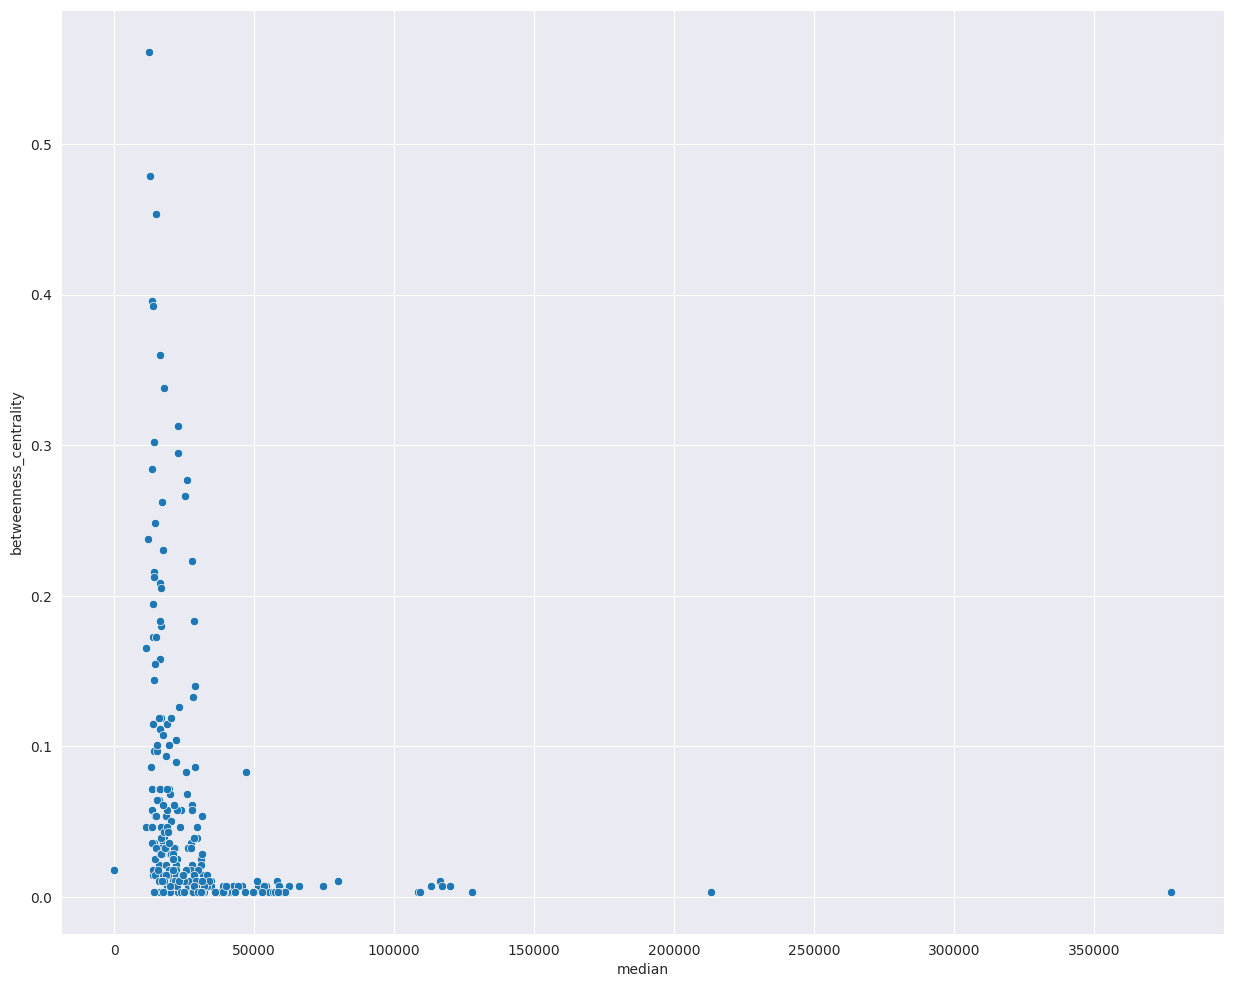

1) betweenness_centrality: коэффициент ранговой корреляции Спирмена = -0.685. Выборки скорелированы p=4.73e-40


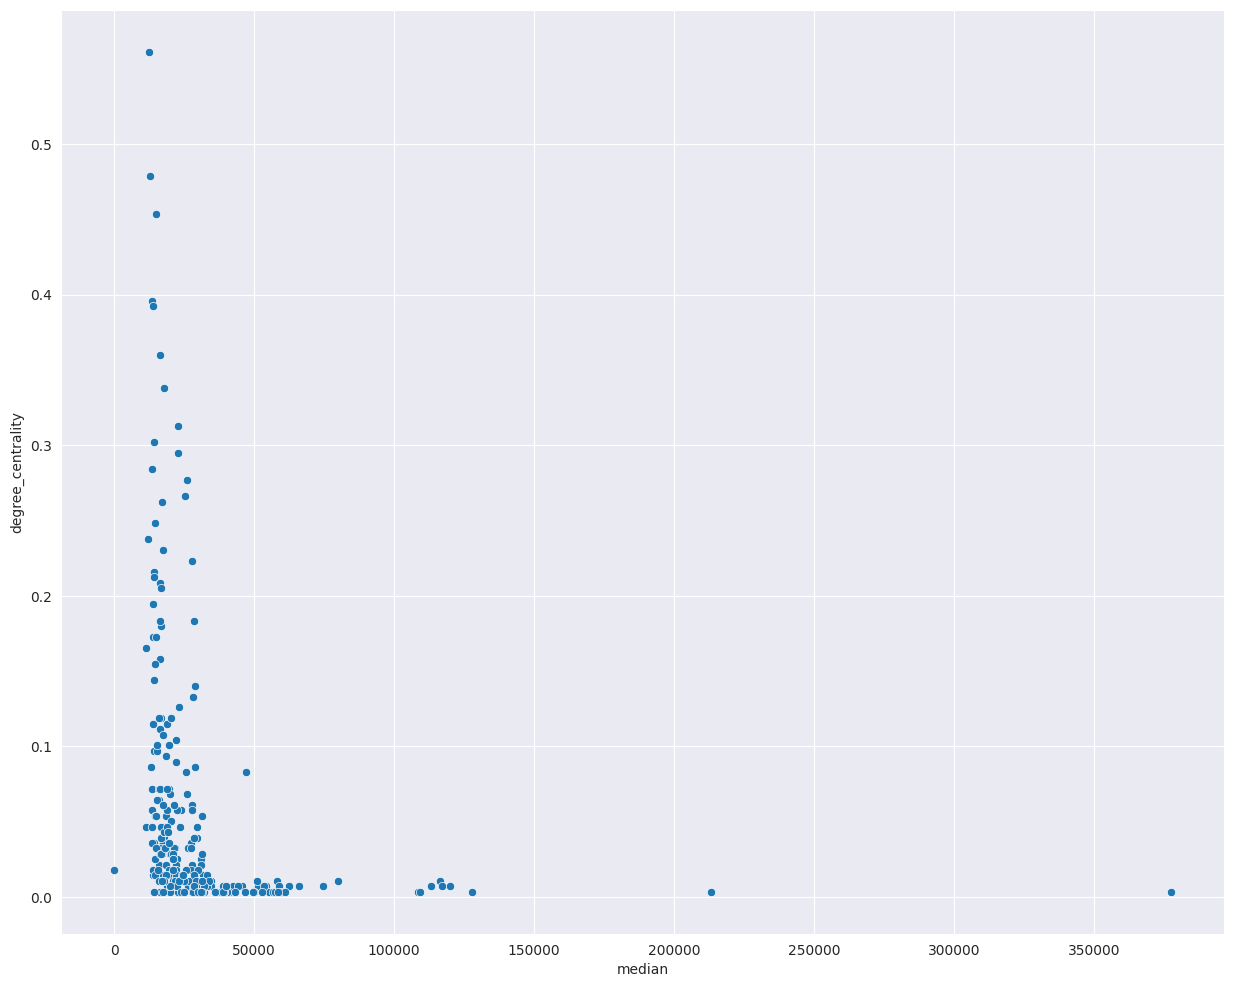

2) degree_centrality: коэффициент ранговой корреляции Спирмена = -0.685. Выборки скорелированы p=4.73e-40


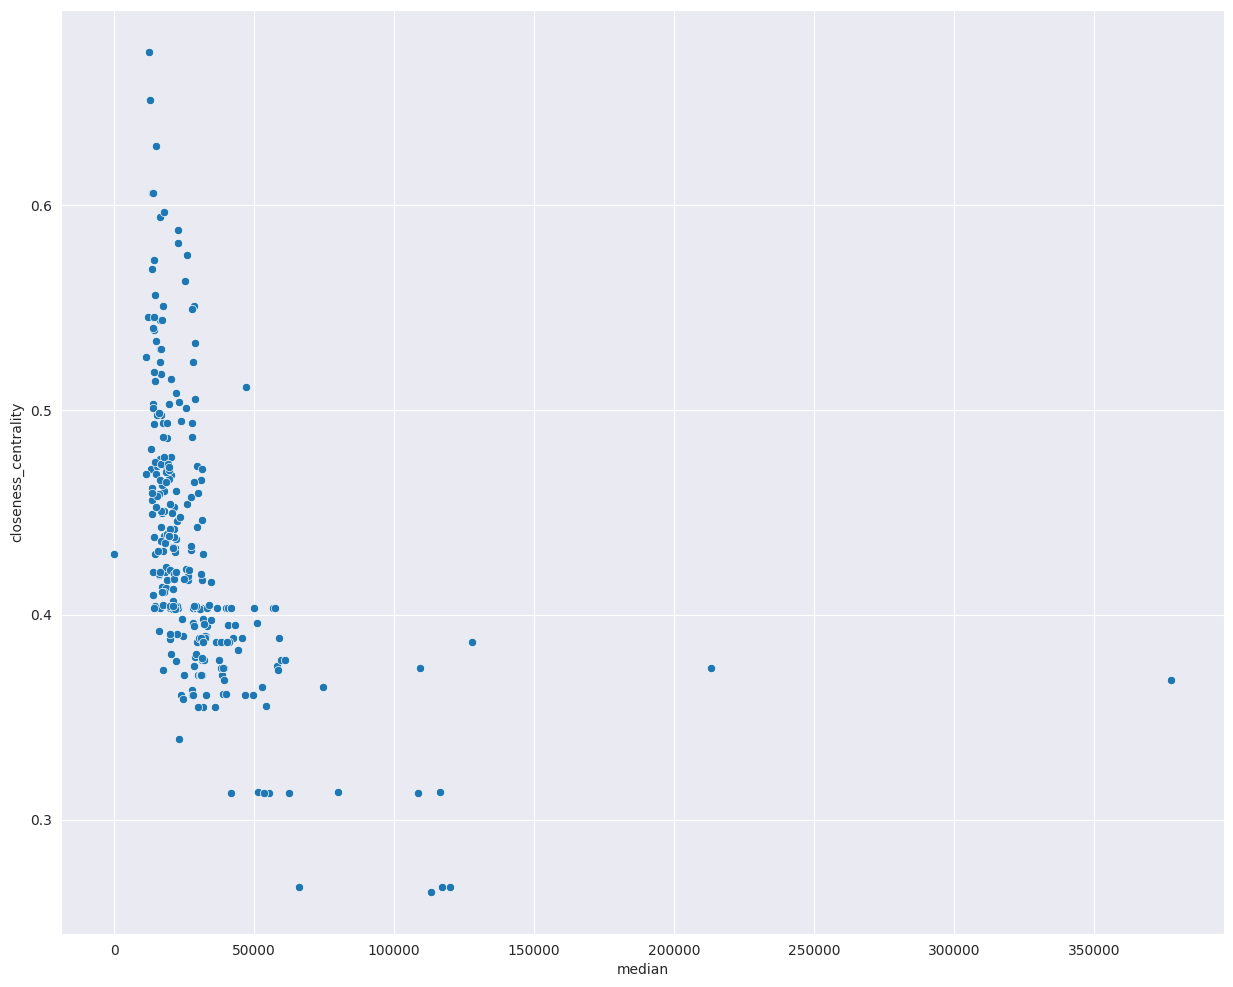

3) closeness_centrality: коэффициент ранговой корреляции Спирмена = -0.7. Выборки скорелированы p=1.83e-42


In [35]:
i = 0
for metric in ['betweenness_centrality', 'degree_centrality', 'closeness_centrality']:
    sns.scatterplot(data=airport_data, y=metric, x='median')
    plt.show()
    coef, p = spearmanr(airport_data[metric], airport_data['median'])
    i += 1
    print(f'{i}) {metric}: коэффициент ранговой корреляции Спирмена = {coef:.3}. Выборки ' + (
        'нескорелированы' if p > 0.05 else 'скорелированы') + f' p={p:.3}')